In [52]:
from time_lstm import T1TimeLSTM, T2TimeLSTM
from time2vec import T1Time2VecLSTM, T2Time2VecLSTM
from dataset_delay_predictions import Dataset_Delay_Prediction, Dataset_Delay_Prediction_from_list, DatasetDelayPredictionStackOverflow
from time_dependant_representation import TimeDepMasking, TimeDepJointEmbedding
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Masking, Layer, LSTM
import os
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt

In [2]:
#names of the two datasets
dataset_names = [
    'stack-overflow-dataset',
    '2019-10_11_12-dataset_delay_prediction'
]

In [3]:
dataset_name = dataset_names[0] #choose the experiment

In [4]:
# load the dataset
pickle_filename = dataset_name.replace('/', '-')
if os.path.exists(pickle_filename):
    print('Reading pickle file...')
    dataset = pickle.load(open(pickle_filename, 'rb'))

Reading pickle file...


In [5]:
training_set_length = dataset.training_set_length
print(training_set_length)
X_train = dataset.full_features_log_dt[:training_set_length]
seqlen = dataset.full_seqlen[:training_set_length]
y_train = np.array(dataset.full_values[:training_set_length])
print(y_train.shape)

5306
(5306, 1)


In [6]:
test_set_length = len(dataset.full_features_log_dt) - training_set_length
X_test = dataset.full_features_log_dt[training_set_length:]
seqlen_test = dataset.full_seqlen[training_set_length:]
y_test = np.array(dataset.full_values[training_set_length:])
print(y_test.shape)

(1327, 1)


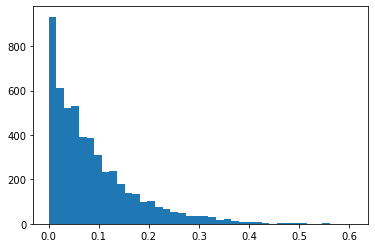

In [7]:
#distribution of target values in train set
plt.hist([y[0] for y in y_train], bins=40)
plt.show()

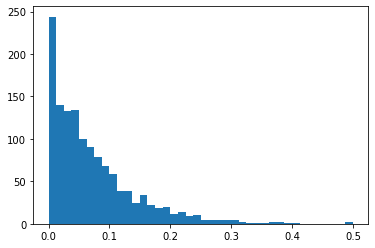

In [8]:
# distribution of target values in test set
plt.hist([y[0] for y in y_test], bins=40)
plt.show()

In [9]:
def Mean_Squarred_Error(np_true_y, np_pred_y):
    return sum([(np_true_y[i][0] - np_pred_y[i][0])**2 for i in range(len(np_true_y))])/len(np_true_y)

In [10]:
padding_value = 0.123456789
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
print(padded_inputs.shape)

(5306, 735, 24)


In [17]:
lstm_units = 50
activation_fn = 'linear'

number_of_epochs = 1
MSE = {}

In [12]:
#LSTMUni
method = 'LSTMUni'

In [13]:
X_train_uni = [[[feat[-2]] for feat in x] for x in X_train]
padded_inputs_uni = tf.keras.preprocessing.sequence.pad_sequences(X_train_uni,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')

In [14]:
print('size of input tensor: ',)
print(padded_inputs_uni.shape)
regressorLSTMUni = Sequential()
regressorLSTMUni.add(Masking(mask_value=padding_value))
regressorLSTMUni.add(LSTM(units=lstm_units))
regressorLSTMUni.add(Dense(units=y_train.shape[1], activation=activation_fn))
regressorLSTMUni.compile(optimizer='adam', loss='mean_squared_error')
regressorLSTMUni.fit(padded_inputs_uni, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

size of input tensor: 
(5306, 735, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5306 samples
5306/5306 [==============================] - 84s 16ms/sample - loss: 0.0074


In [15]:
X_test_uni = []
number_of_event = len(X_train[0][0])
for idx in range(test_set_length):
    seq = X_test[idx]
    ts_list = [[a[-2]] for a in seq]
    X_test_uni.append(ts_list)
X_test_uni = [[[seq[-2]] for seq in x] for x in X_test]
padding_value = 0.123456789
padded_inputs_test_uni = tf.keras.preprocessing.sequence.pad_sequences(X_test_uni,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
predLSTMUni = regressorLSTMUni.predict(padded_inputs_test_uni)

In [19]:
MSE[method] = Mean_Squarred_Error(predLSTMUni,y_test)
print(MSE)

{'LSTMUni': 0.004811876482452877}


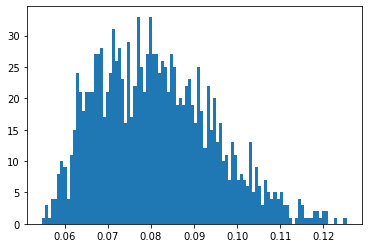

In [22]:
outputs = [pred_[0] for pred_ in predLSTMUni]
plt.hist(outputs, bins=100)
plt.show()

In [23]:
## LSTM Multi

In [24]:
method = 'LSTMMulti'

In [25]:
print('size of input tensor: ',)
print(padded_inputs.shape)
regressorLSTMMulti = Sequential()
regressorLSTMMulti.add(Masking(mask_value=padding_value))
regressorLSTMMulti.add(LSTM(units=lstm_units))
regressorLSTMMulti.add(Dense(units=y_train.shape[1], activation=activation_fn))


regressorLSTMMulti.compile(optimizer='adam', loss='mean_squared_error')
regressorLSTMMulti.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

size of input tensor: 
(5306, 735, 24)
Train on 5306 samples
5306/5306 [==============================] - 86s 16ms/sample - loss: 0.0088


In [26]:
padded_inputs_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
predLSTMMulti = regressorLSTMMulti.predict(padded_inputs_test)

In [27]:
MSE[method] = Mean_Squarred_Error(predLSTMMulti, y_test)
print(MSE)

{'LSTMUni': 0.004811876482452877, 'LSTMMulti': 0.005241006046854248}


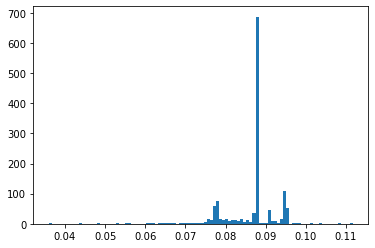

In [28]:
outputs = [pred_[0] for pred_ in predLSTMMulti]
plt.hist(outputs, bins=100)
plt.show()

In [29]:
#T1TimeLSTM
method = 'T1TimeLSTM'

In [30]:
print(padded_inputs.shape)
regressorT1TimeLSTM = Sequential()
regressorT1TimeLSTM.add(Masking(mask_value=padding_value))
regressorT1TimeLSTM.add(T1TimeLSTM(units=lstm_units))
regressorT1TimeLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT1TimeLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT1TimeLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

(5306, 735, 24)
Train on 5306 samples
5306/5306 [==============================] - 118s 22ms/sample - loss: 0.0076


In [32]:
predT1TimeLSTM = regressorT1TimeLSTM.predict(padded_inputs_test)

In [33]:
MSE[method] = Mean_Squarred_Error(predT1TimeLSTM, y_test)

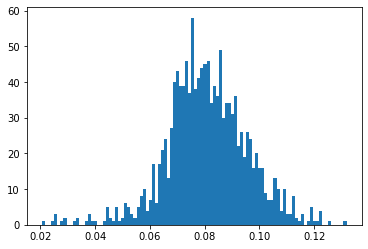

In [34]:
outputs = [pred_[0] for pred_ in predT1TimeLSTM]
plt.hist(outputs, bins=100)
plt.show()

In [31]:
## T2TimeLSTM

In [35]:
method = 'T2TimeLSTM'
print(padded_inputs.shape)
regressorT2TimeLSTM = Sequential()
regressorT2TimeLSTM.add(Masking(mask_value=padding_value))
regressorT2TimeLSTM.add(T2TimeLSTM(units=lstm_units))
regressorT2TimeLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT2TimeLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT2TimeLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)



(5306, 735, 24)
Train on 5306 samples
5306/5306 [==============================] - 150s 28ms/sample - loss: 0.0074


In [36]:
predT2TimeLSTM = regressorT2TimeLSTM.predict(padded_inputs_test)

In [38]:
MSE[method] = Mean_Squarred_Error(predT2TimeLSTM, y_test)
print(MSE)

{'LSTMUni': 0.004811876482452877, 'LSTMMulti': 0.005241006046854248, 'T1TimeLSTM': 0.00494420919500057, 'T2TimeLSTM': 0.0048864377154392525}


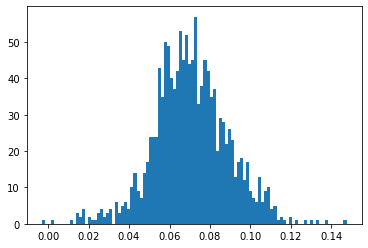

In [39]:
outputs = [pred_[0] for pred_ in predT2TimeLSTM]
plt.hist(outputs, bins=100)
plt.show()

In [ ]:
## TimeDepJointEmbedding

In [40]:
method = 'TimeDepJointEmbedding'
print(padded_inputs.shape)
regressorTimeJoint = Sequential()
regressorTimeJoint.add(Masking(mask_value=padding_value))
regressorTimeJoint.add(TimeDepJointEmbedding(units=lstm_units))
regressorTimeJoint.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorTimeJoint.compile(optimizer='adam', loss='mean_squared_error')
history = regressorTimeJoint.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

(5306, 735, 24)
Train on 5306 samples
5306/5306 [==============================] - 127s 24ms/sample - loss: 0.0076


In [41]:
predTimeJoint = regressorTimeJoint.predict(padded_inputs_test)



In [44]:
MSE[method] = Mean_Squarred_Error(predTimeJoint, y_test)
print(MSE)

{'LSTMUni': 0.004811876482452877, 'LSTMMulti': 0.005241006046854248, 'T1TimeLSTM': 0.00494420919500057, 'T2TimeLSTM': 0.0048864377154392525, 'TimeDepJointEmbedding': 0.005414031781839821}


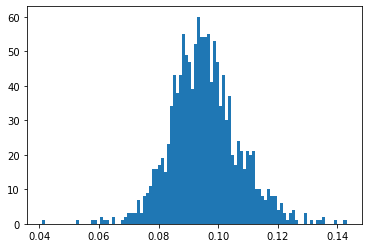

In [45]:
outputs = [pred_[0] for pred_ in predTimeJoint]
plt.hist(outputs, bins=100)
plt.show()

In [51]:
method = 'Naive'
mean_y = sum([y_[0] for y_ in y_train])/len(y_train)
MSE[method] = sum([(y_[0] - mean_y)**2 for y_ in y_test])/len(y_test)
print(MSE)

{'LSTMUni': 0.004811876482452877, 'LSTMMulti': 0.005241006046854248, 'T1TimeLSTM': 0.00494420919500057, 'T2TimeLSTM': 0.0048864377154392525, 'TimeDepJointEmbedding': 0.005414031781839821, 'naive': 0.005222562369081282, 'Naive': 0.005222562369081282}


In [49]:
## Time2Vec

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
#T1Time2Vec

In [54]:
method = 'T1Time2Vec'
print(padded_inputs.shape)
regressorT1Time2VecLSTM = Sequential()
regressorT1Time2VecLSTM.add(Masking(mask_value=padding_value))
regressorT1Time2VecLSTM.add(T1Time2VecLSTM(units=lstm_units))
regressorT1Time2VecLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT1Time2VecLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT1Time2VecLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)


(5306, 735, 24)
Train on 5306 samples
5306/5306 [==============================] - 129s 24ms/sample - loss: 0.0080


In [55]:
predT1Time2VecLSTM = regressorT1Time2VecLSTM.predict(padded_inputs_test)

In [56]:
MSE[method] = Mean_Squarred_Error(predT1Time2VecLSTM, y_test)
print(MSE)

{'LSTMUni': 0.004811876482452877, 'LSTMMulti': 0.005241006046854248, 'T1TimeLSTM': 0.00494420919500057, 'T2TimeLSTM': 0.0048864377154392525, 'TimeDepJointEmbedding': 0.005414031781839821, 'naive': 0.005222562369081282, 'Naive': 0.005222562369081282, 'T1Time2Vec': 0.005064698803219937}


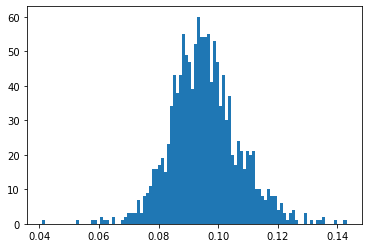

In [57]:
outputs = [pred_[0] for pred_ in predTimeJoint]
plt.hist(outputs, bins=100)
plt.show()

In [ ]:
method = 'T2Time2Vec'
print(padded_inputs.shape)
regressorT2Time2VecLSTM = Sequential()
regressorT2Time2VecLSTM.add(Masking(mask_value=padding_value))
regressorT2Time2VecLSTM.add(T2Time2VecLSTM(units=lstm_units))
regressorT2Time2VecLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT2Time2VecLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT2Time2VecLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)



(5306, 735, 24)
Train on 5306 samples
3100/5306 [================>.............] - ETA: 1:08 - loss: 0.0087

In [ ]:
predT2Time2VecLSTM = regressorT2Time2VecLSTM.predict(padded_inputs_test)

In [ ]:
MSE[method] = Mean_Squarred_Error(predT2Time2VecLSTM, y_test)
print(MSE)

In [ ]:
outputs = [pred_[0] for pred_ in predTimeJoint]
plt.hist(outputs, bins=100)
plt.show()